In [1]:
from utils import CONSTANTS
from utils.binaries import *
from utils.plotting import *
from utils.Auger.FD import XYScanner

11:41:46 (  +33.2s) [INFO   ] -- import logging
11:41:47 (  +148ms) [INFO   ] -- import numpy as np
11:41:47 (    +7ms) [INFO   ] -- import uncertainties
11:41:47 (  +433ms) [INFO   ] -- import pandas as pd
11:41:47 (    +1ms) [WARNING] -- pandas support to be dropped at some point!
11:41:47 (    +2ms) [INFO   ] -- import binaries.tools as tools
11:41:47 (  +350ms) [INFO   ] -- import matplotlib.pyplot as plt
11:41:48 (  +525ms) [INFO   ] -- import seaborn as so
11:41:48 (    +2ms) [INFO   ] -- import plotting.tools as plot
11:41:48 (    +9ms) [DEBUG  ] -- font size set to 9.5
11:41:48 (    +1ms) [DEBUG  ] -- label size set to 13.0
11:41:48 (    +0ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
11:41:48 (    +0ms) [DEBUG  ] -- markersize set to 2.0
11:41:48 (    +0ms) [DEBUG  ] -- usetex set to False


In [2]:
XYScanner.update_runlist_files()

21 bays: 32 written to xy_measurements.pkl


In [3]:
import pickle

with open(f"{CONSTANTS.AUGER_FD_ROOT}/xy_measurements.pkl", 'rb') as f:
    measurements = pickle.load(f)

In [4]:
measurements

{'CO5': [{'XY': '15443x',
   'CalA_closed_shutter': ['15440m23', '15459m23'],
   'CalA_open_shutter': ['15441', '15446'],
   'date': '2022-10-15'},
  {'XY': '15984x',
   'CalA_closed_shutter': ['15982m23', None],
   'CalA_open_shutter': ['15983', '15990'],
   'date': '2023-11-16'}],
 'CO3': [{'XY': '15448',
   'CalA_closed_shutter': ['15440m21', '15459m21'],
   'CalA_open_shutter': ['15447', '15449'],
   'date': '2022-10-15'},
  {'XY': '15941x',
   'CalA_closed_shutter': ['15929m21', '15956m21'],
   'CalA_open_shutter': ['15940', '15950'],
   'date': '2023-11-08'}],
 'CO4': [{'XY': '15451',
   'CalA_closed_shutter': ['15440m22', '15459m22'],
   'CalA_open_shutter': ['15450', '15458'],
   'date': '2022-10-15'},
  {'XY': '15934x',
   'CalA_closed_shutter': ['15929m22', '15956m22'],
   'CalA_open_shutter': ['15930', '15939'],
   'date': '2023-11-08'}],
 'LA3': [{'XY': '#11863',
   'CalA_closed_shutter': ['11861m16', None],
   'CalA_open_shutter': ['11862', None],
   'date': '2022-10-19'},

In [144]:
class XYComparisonGrid():

    data_path : str = f'{CONSTANTS.AUGER_FD_ROOT}/xy_measurements.pkl'
    n_bays : dict = {t : 6 if t != 'HE' else 3 for t in['LL', 'LM', 'LA', 'CO', 'HE']}

    def __init__(self, telescopes = ['LL', 'LM', 'LA', 'CO', 'HE'], dates = None) -> None :

        import pickle
        with open(f'{CONSTANTS.AUGER_FD_ROOT}/xy_measurements.pkl', 'rb') as f:
            measurements = pickle.load(f)

        self.n_rows, self.n_cols, dates = self.get_rows_and_cols(measurements, telescopes, dates)
        self.xlabels = [[f'{t}{n}' for n in range(1, self.n_bays[t] + 1)] for t in telescopes]
        self.xlabels = [bay for site in self.xlabels for bay in site]
        self.ylabels = sorted(dates)

        print('columns (sites):', self.xlabels)
        print('rows    (dates):', self.ylabels)

        self.grid_data = {bay : {date : [] for date in self.ylabels} for bay in self.xlabels}
        for bay in self.xlabels:

            try:
                first_measurement = measurements[bay][0]
                date = self.get_month(first_measurement['date'])

                self.grid_data[bay][date] = first_measurement

                if len(measurements[bay]) == 1: continue
                for measurement in measurements[bay][1:]:
                    self.grid_data[bay][self.get_month(measurement['date'])] = [measurement, first_measurement]
            except KeyError: continue


    def plot(self) -> plt.Figure :

        from matplotlib.gridspec import GridSpec
        from itertools import product

        fig = plt.figure(figsize=(2 * self.n_cols + 0.2, 2 * self.n_rows))
        gs = GridSpec(
            self.n_rows,
            self.n_cols + 1,
            figure=fig,
            width_ratios = [1 for _ in range(self.n_cols)] + [0.2],
            height_ratios = [1 for _ in range(self.n_rows)]
        )

        gs.update(left=0.05, right=0.95, wspace=0.02, hspace=0.02)
        axes = [fig.add_subplot(gs[i, j]) for i, j in product(range(self.n_rows), range(self.n_cols))]
        axes = np.reshape(axes, (self.n_cols, self.n_rows))

        for i_col, (col_ax, col_data) in enumerate(zip(axes, self.grid_data.values())):
            for j_row, (ax, data) in enumerate(zip(col_ax, col_data)):
                self.draw_axis(j_row, i_col, ax, data)
       
        # cax = fig.add_subplot(gs[:, -1])


        return fig

    def draw_axis(self, row, col, ax, data) -> None :

        has_label = False
        if col == 0: 
            ax.set_ylabel(self.ylabels[row])
            has_label = True
        if row == 0:
            ax.set_title(self.xlabels[col])
            has_label = True

        print(row, col)


    @staticmethod
    def get_rows_and_cols(measurements, telescopes, dates) -> tuple[int, int, list[str]] :

        n_cols = sum([6 if t != 'HE' else 3 for t in telescopes])

        if dates is None:
            times, n_rows = [], 0
            for telescope in measurements.values():
                for runs in telescope:
                    times.append('-'.join(runs['date'].split('-')[:-1]))

            times = np.unique(times)
            n_rows += len(times)

        return n_rows, n_cols, list(times)

    
    @staticmethod
    def hide_axis(ax : plt.Axes, has_label : bool) -> None :

        if has_label:
            ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
        else:
            ax.axis('off')


    @staticmethod
    def get_month(date_str) -> str :
        return '-'.join(date_str.split('-')[:-1])

In [145]:
test = XYComparisonGrid(telescopes = ['LM', 'HE'])

columns (sites): ['LM1', 'LM2', 'LM3', 'LM4', 'LM5', 'LM6', 'HE1', 'HE2', 'HE3']
rows    (dates): ['2022-10', '2023-10', '2023-11']


0 0
1 0
2 0
0 1
1 1
2 1
0 2
1 2
2 2
0 3
1 3
2 3
0 4
1 4
2 4
0 5
1 5
2 5
0 6
1 6
2 6
0 7
1 7
2 7
0 8
1 8
2 8


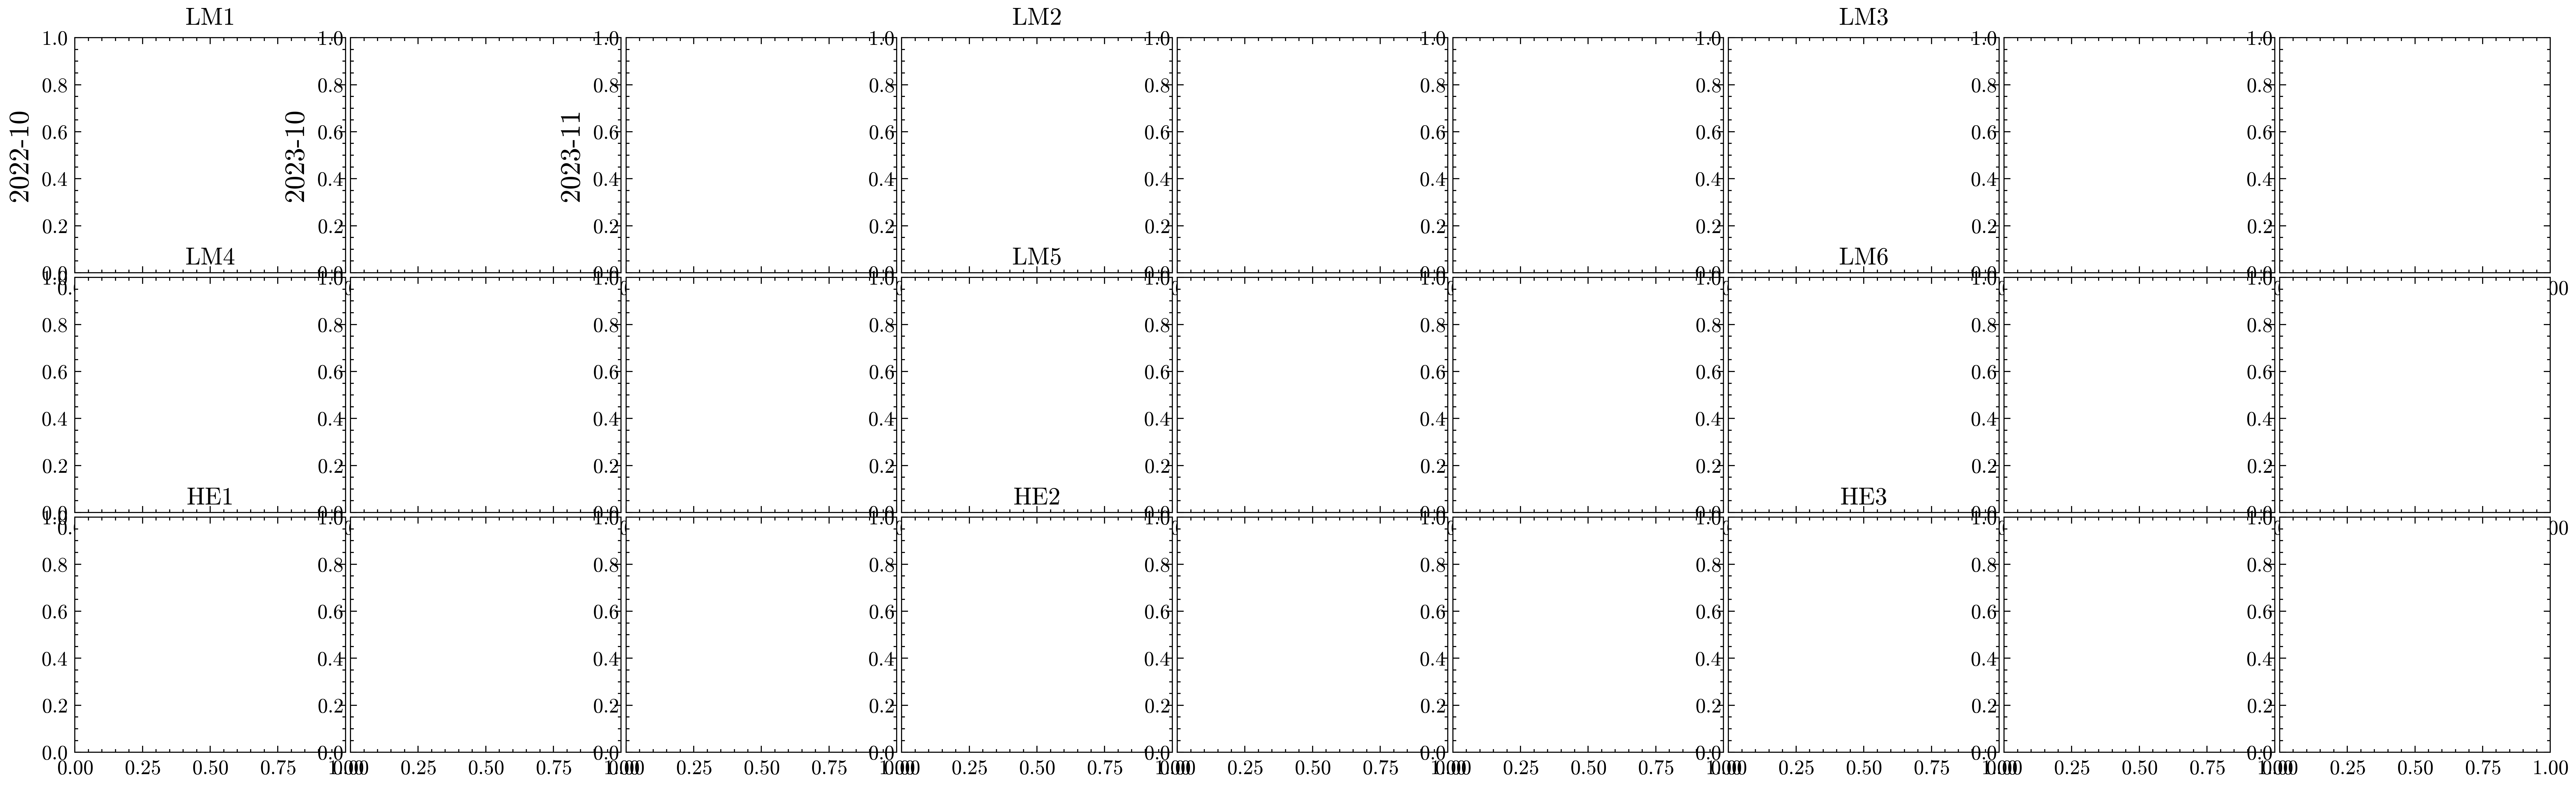

In [146]:
_ = test.plot()

In [ ]:
from datetime import datetime

times = []

for telescope in measurements.values():
    for runs in telescope:
        times.append('-'.join(runs['date'].split('-')[:-1]))

times = np.unique(times)


In [ ]:
print(times)

In [6]:
measurements['LM5']

[{'XY': '12825',
  'CalA_closed_shutter': ['12816m11', None],
  'CalA_open_shutter': ['12824', '12826'],
  'date': '2023-11-14'}]